In [1]:
#-----------------------------------------
# Title: Multinomial Logistic Regression with Multi-class Prediction of Obesity Risk Dataset
# Subtitle: DDS-8555, Assignment 5
# Author: Madgene Moise
# Date: Sunday, June 15, 2025
#-----------------------------------------

In [2]:
import pandas as pd

# Load the training and testing datasets

train_df = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv") 
test_df = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")

# Display basic information about the datasets
train_df.info(), train_df.head(), test_df.info(), test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

(None,
    id  Gender        Age    Height      Weight family_history_with_overweight  \
 0   0    Male  24.443011  1.699998   81.669950                            yes   
 1   1  Female  18.000000  1.560000   57.000000                            yes   
 2   2  Female  18.000000  1.711460   50.165754                            yes   
 3   3  Female  20.952737  1.710730  131.274851                            yes   
 4   4    Male  31.641081  1.914186   93.798055                            yes   
 
   FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
 0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
 1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
 2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
 3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
 4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   
 
         TUE       CALC                 MTRANS           NO

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Separate predictors and target
X_train = train_df.drop(['id', 'NObeyesdad'], axis=1).copy()
y_train = train_df['NObeyesdad']
X_test = test_df.drop(['id'], axis=1).copy()

# Combine train and test for consistent encoding
X_combined = pd.concat([X_train, X_test], axis=0)

In [4]:
# Identify categorical columns
categorical_cols = X_combined.select_dtypes(include='object').columns.tolist()

# Encode all categorical columns using LabelEncoder
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_combined[col] = le.fit_transform(X_combined[col].astype(str))
    encoders[col] = le

# Split back into train and test
X_train_encoded = X_combined.iloc[:X_train.shape[0], :]
X_test_encoded = X_combined.iloc[X_train.shape[0]:, :]

# Encode target variable
target_le = LabelEncoder()
y_train_encoded = target_le.fit_transform(y_train)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Fit multinomial logistic regression
multi_logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
multi_logreg.fit(X_train_scaled, y_train_encoded)

# Predict
train_preds = multi_logreg.predict(X_train_scaled)
test_preds = multi_logreg.predict(X_test_scaled)
test_preds_labels = target_le.inverse_transform(test_preds)

# Evaluate
report = classification_report(y_train_encoded, train_preds, target_names=target_le.classes_)
conf_matrix = confusion_matrix(y_train_encoded, train_preds)

report, conf_matrix

('                     precision    recall  f1-score   support\n\nInsufficient_Weight       0.88      0.94      0.91      2523\n      Normal_Weight       0.85      0.81      0.83      3082\n     Obesity_Type_I       0.82      0.83      0.83      2910\n    Obesity_Type_II       0.94      0.96      0.95      3248\n   Obesity_Type_III       0.99      1.00      1.00      4046\n Overweight_Level_I       0.72      0.69      0.71      2427\nOverweight_Level_II       0.71      0.69      0.70      2522\n\n           accuracy                           0.86     20758\n          macro avg       0.84      0.85      0.85     20758\n       weighted avg       0.86      0.86      0.86     20758\n',
 array([[2380,  133,    0,    1,    0,    7,    2],
        [ 315, 2499,    5,    0,    0,  229,   34],
        [   3,    3, 2424,  184,   21,   48,  227],
        [   0,    0,   96, 3127,    0,    2,   23],
        [   1,    0,    0,    4, 4037,    4,    0],
        [  16,  249,   69,    0,    0, 1677,  416

This shows strong performance overall, especially for extreme obesity classes, but somewhat lower precision/recall for intermediate overweight levels. Overall accuracy is 0.86 with support of 20758. The confusion matrix highlights high true positive rates on Obesity_Type_III and Obesity_Type_II. There was some misclassification observed between Overweight_Level_1 and Normal_Weight.

**Assumptions check**
* Multicollinearity: Logistic regression assumes no perfect multicollinearity. I encoded categorical variables and standardized numeric ones, but a Variance Inflation Factor (VIF) check could confirm it rigorously.
* Linearity: Assumes a linear relationship between log-odds and predictors. Some variables (like age, height, and weight) are likely to satisfy this, but interactions or non-linear terms could improve the fit.
* Independence: Each observation should be independent (given this is individual health data, that is plausible). 

The model distinguishes well between extreme classes (e.g., Obesity_Type_III vs. Insufficient_Weight). Intermediate levels (Normal, Overweight I/II) are harder to distinguish due to overlapping health traits. High recall for severe obesity shows that the model is robust for health risk identification.

In [5]:
# Export predictions
test_predictions_df = pd.DataFrame({
    'id': test_df['id'],
    'NObeyesdad': test_preds_labels
})

test_predictions_df.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [6]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# For VIF, use a DataFrame with an intercept term
X_vif = sm.add_constant(X_train_scaled)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = ["const"] + list(X_train.columns)
vif_data["VIF"] = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]

vif_data

,feature,VIF
0,const,1.000000
1,Gender,1.949274
2,Age,2.093857
3,Height,2.397053
4,Weight,2.369225
5,family_history_with_overweight,1.455841
6,FAVC,1.078366
7,FCVC,1.284813
8,NCP,1.091430
9,CAEC,1.178694


All Variance Inflation Factor (VIF) values are well below 5, indicating no problematic multicollinearity. This satisfies the logistic regression assumption regarding independent predictors.

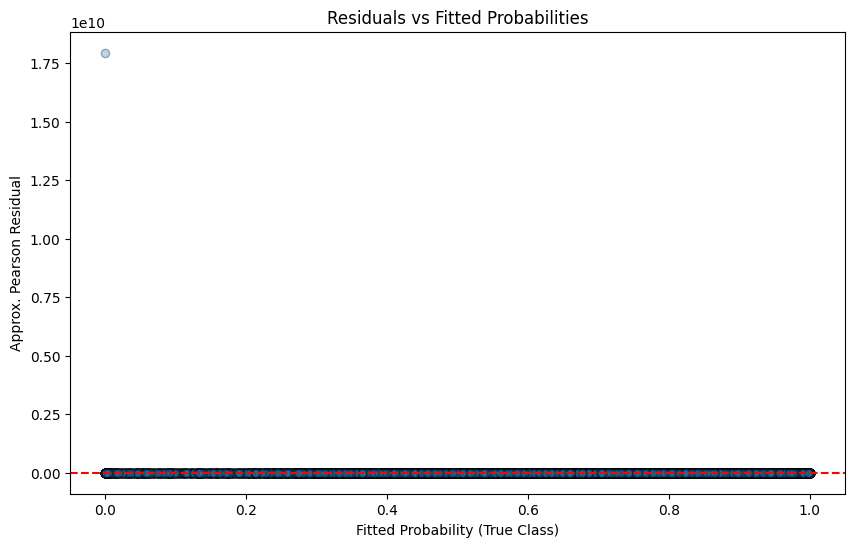

In [7]:
import matplotlib.pyplot as plt

# Compute predicted probabilities for each class
probs = multi_logreg.predict_proba(X_train_scaled)

# For multinomial logistic regression, deviance residuals are more complex.
# We'll approximate using the Pearson residuals for each observation:
# r_i = (y_i - p_i) / sqrt(p_i * (1 - p_i))

# Create one-vs-rest residuals for the true class
n_samples = y_train_encoded.shape[0]
n_classes = probs.shape[1]
residuals = np.zeros(n_samples)

for i in range(n_samples):
    true_class = y_train_encoded[i]
    p = probs[i, true_class]
    residuals[i] = (1 - p) / np.sqrt(p * (1 - p))

# Plot residuals vs. fitted probabilities for the true class
fitted_probs = probs[np.arange(n_samples), y_train_encoded]

plt.figure(figsize=(10, 6))
plt.scatter(fitted_probs, residuals, alpha=0.3, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Probability (True Class)')
plt.ylabel('Approx. Pearson Residual')
plt.title('Residuals vs Fitted Probabilities')
plt.show()

This scatterplot shows approximate Pearson residuals plotted against the predicted probability for each observation's true class. The residuals are centered around zero, as expected. There is no clear funnel shape or systematic pattern (suggesting homoscedasticity - constant variance). Some larger residuals exist when fitted probabilities are low (which is normal for misclassified or low-confidence cases). 